In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (auc, classification_report, roc_auc_score, accuracy_score,
                             f1_score, log_loss, roc_curve, confusion_matrix, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler
from math import sin, cos, sqrt, atan2, radians
import random
import statsmodels.api as sm

In [2]:
def distance(lat1, lon1, lat2, lon2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance

In [3]:
import pandas as pd
import numpy as np
from pandas import DataFrame,Series
##mm_data = pd.read_excel('BPI.xlsx')

mm_data = pd.read_csv('new_data.csv',encoding='cp1252')
new_data = pd.read_csv('pre_data.csv',encoding='cp1252')


In [4]:
#get columns

mm_data.columns

Index(['team1_id', 'team1_score', 'team2_id', 'team2_score', 'WLoc', 'num_ot',
       'team1_position', 'team2_position', 'team1_seed', 'team2_seed',
       ...
       'game_id', 'result', 'Factor1', 'Factor2', 'Factor3', 'Factor4',
       'Factor5', 'team1_score.1', 'team2_score.1', 'coach_difference'],
      dtype='object', length=115)

In [5]:
#feature transformation of distance

mm_data['dist1'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
mm_data['dist2'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)
new_data['dist1'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team1_lat'], row['team1_long']), axis=1)
new_data['dist2'] = mm_data.apply(lambda row: distance(row['host_lat'], row['host_long'], row['team2_lat'], row['team2_long']), axis=1)

In [6]:
mm_data['diff_dist'] = mm_data['dist1'] - mm_data['dist2']
new_data['diff_dist'] = new_data['dist1'] - new_data['dist2']

In [7]:
###E(W%) = points scored^11.5 / (points scored^11.5+points allowed^11.5)

mm_data['exp_win1'] = (mm_data['team1_adjoe']**11.5)/ ((mm_data['team1_adjde']**11.5)+(mm_data['team1_adjoe']**11.5))
mm_data['exp_win2'] = (mm_data['team2_adjoe']**11.5)/ ((mm_data['team2_adjde']**11.5)+(mm_data['team2_adjoe']**11.5))
new_data['exp_win1'] = (new_data['team1_adjoe']**11.5)/ ((new_data['team1_adjde']**11.5)+(new_data['team1_adjoe']**11.5))
new_data['exp_win2'] = (new_data['team2_adjoe']**11.5)/ ((new_data['team2_adjde']**11.5)+(new_data['team2_adjoe']**11.5))

In [8]:
####P(W) = (A - A B) / (A + B - 2A*B)
mm_data['team1_log5'] = (mm_data['exp_win1'] - (mm_data['exp_win1']*mm_data['exp_win2']))/ (mm_data['exp_win1']+mm_data['exp_win2']-(2*mm_data['exp_win1']*mm_data['exp_win2']))

new_data['team1_log5'] = (new_data['exp_win1'] - (new_data['exp_win1']*new_data['exp_win2']))/ (new_data['exp_win1']+new_data['exp_win2']-(2*new_data['exp_win1']*new_data['exp_win2']))

In [9]:
mm_data[['team1_adjoe','team1_teamname','Team1_BPI','season','team2_teamname','Team2_BPI','team1_adjde','exp_win1','exp_win2','team1_log5']].tail()

#'Factor1','Factor2','Factor3','Factor4','Factor5'

,team1_adjoe,team1_teamname,Team1_BPI,season,team2_teamname,Team2_BPI,team1_adjde,exp_win1,exp_win2,team1_log5
1107,96.5408,Florida A&M,NaN,2004,Kentucky,NaN,106.5397,0.243544,0.933593,0.022388
1108,110.1034,West Virginia,16.6,2008,Xavier,13.5,94.6948,0.849891,0.892551,0.405326
1109,109.0495,USC,NaN,2007,North Carolina,NaN,96.3581,0.805793,0.955291,0.162611
1110,104.7221,Florida St,13.1,2009,Wisconsin,15.9,89.9489,0.851800,0.859794,0.483807
1111,107.5025,Illinois,6.8,2013,Miami FL,3.5,94.6620,0.811963,0.902941,0.317016


In [10]:
###Seed Diff
mm_data['seed_diff'] = mm_data['team1_seed'] - mm_data['team2_seed']
new_data['seed_diff'] = new_data['team1_seed'] - new_data['team2_seed']

In [11]:
## BPI difference
mm_data['BPI_Diff']=mm_data['Team1_BPI'] -mm_data['Team2_BPI']
new_data['BPI_Diff']=new_data['team1_bpi'] -new_data['team2_bpi']


In [12]:
mm_data[['game_id','exp_win1','exp_win2','diff_dist','team1_log5','team1_id','team2_id','Team1_BPI', 'Team2_BPI','BPI_Diff']].tail()

,game_id,exp_win1,exp_win2,diff_dist,team1_log5,team1_id,team2_id,Team1_BPI,Team2_BPI,BPI_Diff
1107,2004-1246-1197,0.243544,0.933593,814.897910,0.022388,1197,1246,NaN,NaN,NaN
1108,2008-1462-1452,0.849891,0.892551,391.905156,0.405326,1452,1462,16.6,13.5,3.1
1109,2007-1314-1425,0.805793,0.955291,3238.100454,0.162611,1425,1314,NaN,NaN,NaN
1110,2009-1458-1199,0.851800,0.859794,1004.110917,0.483807,1199,1458,13.1,15.9,-2.8
1111,2013-1274-1228,0.811963,0.902941,-530.831880,0.317016,1228,1274,6.8,3.5,3.3


In [13]:
#Split Data
mm_data.dropna(subset=['team1_log5'], inplace=True)

mm_data['Score_Diff']=mm_data['team1_score']-mm_data['team2_score']
mm_data['team1_win'] = mm_data['Score_Diff'].map(lambda x: 1 if x > 0 else 0)


mm_data['team1_win'].tail()

1107    0
1108    0
1109    0
1110    0
1111    0
Name: team1_win, dtype: int64

In [14]:
def shuffle(df):     
    df = df.reindex(np.random.permutation(df.index)).copy()
    return df.reset_index(drop=True)

my_randoms = random.sample(range(len(new_data)), int(len(new_data)/2))
##m_data[(~mm_data.index.isin(my_randoms))&(mm_data.season == 2015).shape

In [15]:
mm_data = shuffle(mm_data)
#new_data = shuffle(new_data)
##len(new_data['game_id'])
len(mm_data['game_id'])


1112

In [16]:

my_randoms = random.sample(range(len(mm_data)), int(len(mm_data)/2))
#my_randoms1 = random.sample(range(len(new_data)), int(len(new_data)/2))

In [17]:
#mm_data[(~mm_data.index.isin(my_randoms))&(mm_data.season==2018)].shape
mm_data[(~mm_data.index.isin(my_randoms))].shape

(556, 125)

In [18]:
mm_data_1 = mm_data[~mm_data.index.isin(my_randoms)][['game_id', 'season','team1_win',  'exp_win2', 'exp_win1', 'diff_dist', 'team1_log5',
 'team2_id', 'team1_id','seed_diff','BPI_Diff','Team1_BPI','Team2_BPI']].reset_index(drop=True)
mm_data_2 = mm_data[mm_data.index.isin(my_randoms)][['game_id', 'season', 'team1_win','exp_win2', 'exp_win1','diff_dist', 'team1_log5',
 'team2_id', 'team1_id','seed_diff','BPI_Diff','Team1_BPI','Team2_BPI']].reset_index(drop=True)
len(mm_data_2)

556

In [19]:
##mm_data_2['team1_win'] = mm_data_2['team1_win'].apply(lambda x: 1 if x==0 else 0)
##mm_data_2['diff_dist'] = mm_data_2['diff_dist']*-1
##mm_data_2['team1_log5'] = 1-mm_data_2['team1_log5']
##mm_data['seed_diff'] = mm_data['seed_diff']*-1
##mm_data_2.columns = ['game_id', 'season', 'team1_win', 'exp_win2', 'exp_win1', 'team1_score', 'team2_score', 'diff_dist', 'team1_log5',
## 'team2_id', 'team1_id','seed_diff','Score_Diff','BPI_Diff','Team1_BPI','Team2_BPI']
##

In [20]:
mm_train = pd.concat([mm_data_2, mm_data_1])


In [21]:
#mm_data_2017 = mm_train[mm_train['season'] == 2017].reset_index(drop=True)
#mm_data_else =  mm_train[mm_train['season'] != 2017 ].reset_index(drop=True)
#mm_data_2018 = mm_train[mm_train['season'] == 2018].reset_index(drop = True)
#mm_data_else2 = mm_train[mm_train['season'] != 2018].reset_index(drop=True)


In [22]:
##Innitial Check
#mm_data_else.groupby('team1_win')['team1_log5'].mean()
##mm_data_2017[['team1_id','team2_id']].groupby(['team1_id','team2_id'])['team2_id'].count()


In [23]:
#mm_data_else.groupby('team1_win')['seed_diff'].mean()


In [24]:
#mm_data_else.groupby('team1_win')['diff_dist'].mean()

In [25]:

###Train Logit--LOG5
scaler = StandardScaler()
#mm_train_scaled  = scaler.fit_transform(mm_data_else[['team1_log5']])
#mm_train_scaled2 = scaler.fit_transform(mm_data_else2[['team1_log5']])
mm_train_scaled_log5  = scaler.fit_transform(mm_data_1[['team1_log5']])


logit = LogisticRegression()
logit.fit(mm_train_scaled_log5, mm_data_1['team1_win'])

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
#smlogit = sm.Logit(mm_data_else['team1_win'], mm_data_else['team1_log5']).fit()
#smlogit2 = sm.Logit(mm_data_else2['team1_win'],mm_data_else2['team1_log5']).fit()
#smlogit.summary()
smlogit = sm.Logit(mm_train['team1_win'], mm_train['team1_log5']).fit()
#smlogit2 = sm.Logit(mm_data_else2['team1_win'],mm_data_else2['team1_log5']).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.669395
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                 1112
Model:                          Logit   Df Residuals:                     1111
Method:                           MLE   Df Model:                            0
Date:                Thu, 04 Apr 2019   Pseudo R-squ.:                 0.03426
Time:                        21:26:12   Log-Likelihood:                -744.37
converged:                       True   LL-Null:                       -770.78
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
team1_log5     0.8108      0.114      7.127      0.000       0.588       1.034
==============================================================================
"""

In [27]:

mm_train['preds'] = logit.predict_proba(scaler.fit_transform(mm_train[['team1_log5']]))[:,1]
mm_data_2['preds'] = logit.predict_proba(scaler.fit_transform(mm_data_2[['team1_log5']]))[:,1]
mm_train['prediction'] = logit.predict(scaler.fit_transform(mm_train[['team1_log5']]))
mm_data_2['prediction'] = logit.predict(scaler.fit_transform(mm_data_2[['team1_log5']]))

In [ ]:
#mm_train[['team1_log5','team1_win','preds','prediction']]
#mm_data_2018[['team1_log5','team1_win','preds','prediction']]

In [ ]:
#mm_train.groupby('team1_win')['preds'].mean()

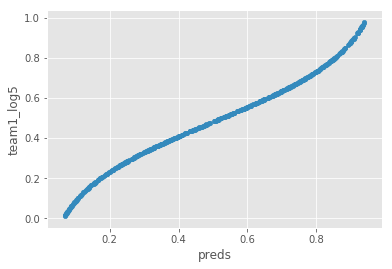

In [28]:
mm_data_2.plot(kind='scatter', x='preds',y='team1_log5')

In [29]:
confusion_matrix(mm_train['team1_win'], mm_train['prediction'])

array([[388, 169],
       [152, 403]], dtype=int64)

In [30]:
accuracy_score(mm_data_2['team1_win'], mm_data_2['prediction'])

0.7266187050359713

In [31]:
precision_score(mm_data_2['team1_win'], mm_data_2['prediction'])

0.7040816326530612

In [32]:
recall_score(mm_data_2['team1_win'], mm_data_2['prediction'])

0.7610294117647058

In [33]:
f1_score(mm_data_2['team1_win'], mm_data_2['prediction'])

0.7314487632508834

In [34]:
log_loss(mm_data_2['team1_win'].values, mm_data_2['preds'].values)

0.5514498398731853

In [35]:
def plot_roc(fpr, tpr, roc_auc):
    """Plots the ROC curve for the win probability model along with
    the AUC.
    """
    fig, ax = plt.subplots()
    ax.set(title='Receiver Operating Characteristic',
           xlim=[0, 1], ylim=[0, 1], xlabel='False Positive Rate',
           ylabel='True Positive Rate')
    ax.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='lower right')

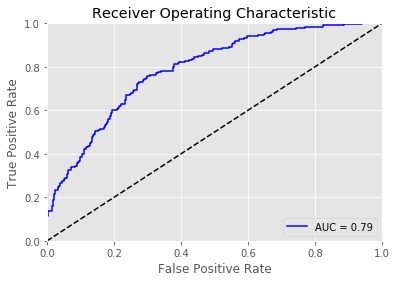

In [36]:
fpr, tpr, thresholds = roc_curve(mm_data_2['team1_win'].values, mm_data_2['preds'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [37]:
roc_auc_score(mm_data_2['team1_win'].values, mm_data_2['preds'].values)

0.7894443869096934

In [38]:
#DIST
mm_train_scaled_dist  = scaler.fit_transform(mm_data_1[['diff_dist']])
logit.fit(mm_train_scaled_dist, mm_data_1['team1_win'])

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [39]:

smlogit = sm.Logit(mm_train['team1_win'], mm_train['diff_dist']).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.686198
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                 1112
Model:                          Logit   Df Residuals:                     1111
Method:                           MLE   Df Model:                            0
Date:                Thu, 04 Apr 2019   Pseudo R-squ.:                 0.01002
Time:                        21:31:51   Log-Likelihood:                -763.05
converged:                       True   LL-Null:                       -770.78
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
diff_dist     -0.0002   5.27e-05     -3.878      0.000      -0.000      -0.000
==============================================================================
"""

In [40]:
mm_train['preds'] = logit.predict_proba(scaler.fit_transform(mm_train[['diff_dist']]))[:,1]
mm_data_2['preds'] = logit.predict_proba(scaler.fit_transform(mm_data_2[['diff_dist']]))[:,1]
mm_train['prediction'] = logit.predict(scaler.fit_transform(mm_train[['diff_dist']]))
mm_data_2['prediction'] = logit.predict(scaler.fit_transform(mm_data_2[['diff_dist']]))

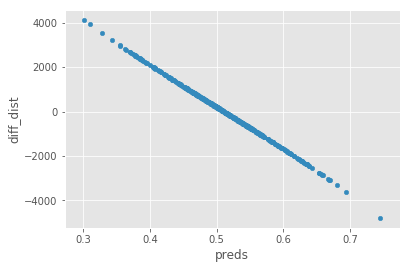

In [41]:
mm_data_2.plot(kind='scatter', x='preds',y='diff_dist')

In [42]:
confusion_matrix(mm_train['team1_win'], mm_train['prediction'])

array([[275, 282],
       [196, 359]], dtype=int64)

In [43]:
accuracy_score(mm_data_2['team1_win'], mm_data_2['prediction'])

0.5431654676258992

In [44]:
precision_score(mm_data_2['team1_win'], mm_data_2['prediction'])

0.5279503105590062

In [45]:
recall_score(mm_data_2['team1_win'], mm_data_2['prediction'])

0.625

In [46]:
f1_score(mm_data_2['team1_win'], mm_data_2['prediction'])

0.5723905723905723

In [47]:
log_loss(mm_data_2['team1_win'].values, mm_data_2['preds'].values)

0.6878816291747344

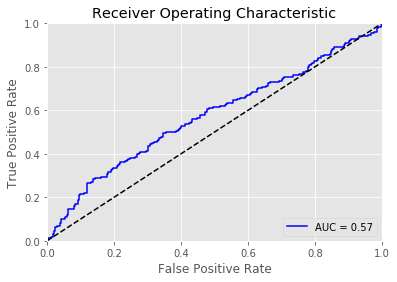

In [48]:
fpr, tpr, thresholds = roc_curve(mm_data_2['team1_win'].values, mm_data_2['preds'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [49]:
roc_auc_score(mm_data_2['team1_win'].values, mm_data_2['preds'].values)

0.5739566072908037

In [50]:
###BPI
mm_data_1.dropna(subset=['BPI_Diff'], inplace=True)
mm_data_2.dropna(subset=['BPI_Diff'], inplace=True)
mm_train.dropna(subset=['BPI_Diff'], inplace=True)
mm_train_scaled_BPI  = scaler.fit_transform(mm_data_1[['BPI_Diff']])
logit.fit(mm_train_scaled_BPI, mm_data_1['team1_win'])                                                

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [51]:
smlogit = sm.Logit(mm_train['team1_win'], mm_train['BPI_Diff']).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.603685
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                  680
Model:                          Logit   Df Residuals:                      679
Method:                           MLE   Df Model:                            0
Date:                Thu, 04 Apr 2019   Pseudo R-squ.:                  0.1290
Time:                        21:33:25   Log-Likelihood:                -410.51
converged:                       True   LL-Null:                       -471.29
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
BPI_Diff       0.1035      0.011      9.730      0.000       0.083       0.124
==============================================================================
"""

In [52]:
mm_train['preds'] = logit.predict_proba(scaler.fit_transform(mm_train[['BPI_Diff']]))[:,1]
mm_data_2['preds'] = logit.predict_proba(scaler.fit_transform(mm_data_2[['BPI_Diff']]))[:,1]
mm_train['prediction'] = logit.predict(scaler.fit_transform(mm_train[['BPI_Diff']]))
mm_data_2['prediction'] = logit.predict(scaler.fit_transform(mm_data_2[['BPI_Diff']]))

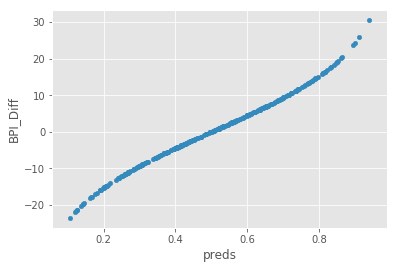

In [53]:
mm_data_2.plot(kind='scatter', x='preds',y='BPI_Diff')

In [54]:
confusion_matrix(mm_train['team1_win'], mm_train['prediction'])

array([[229, 107],
       [101, 243]], dtype=int64)

In [55]:
accuracy_score(mm_data_2['team1_win'], mm_data_2['prediction'])

0.7055393586005831

In [56]:
precision_score(mm_data_2['team1_win'], mm_data_2['prediction'])

0.7151162790697675

In [57]:
recall_score(mm_data_2['team1_win'], mm_data_2['prediction'])

0.7028571428571428

In [58]:
f1_score(mm_data_2['team1_win'], mm_data_2['prediction'])

0.7089337175792507

In [59]:
log_loss(mm_data_2['team1_win'].values, mm_data_2['preds'].values)

0.5951834136900596

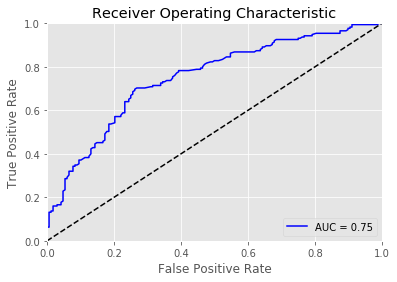

In [60]:
fpr, tpr, thresholds = roc_curve(mm_data_2['team1_win'].values, mm_data_2['preds'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [61]:
roc_auc_score(mm_data_2['team1_win'].values, mm_data_2['preds'].values)

0.7493197278911565

In [62]:
mm_data_1.dropna(subset=['seed_diff'], inplace=True)
mm_data_2.dropna(subset=['seed_diff'], inplace=True)
mm_train.dropna(subset=['seed_diff'], inplace=True)
mm_train_scaled_seed  = scaler.fit_transform(mm_data_1[['seed_diff']])
logit.fit(mm_train_scaled_seed, mm_data_1['team1_win'])

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [64]:
smlogit = sm.Logit(mm_train['team1_win'], mm_train['seed_diff']).fit()
smlogit.summary()

Optimization terminated successfully.
         Current function value: 0.578111
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              team1_win   No. Observations:                  680
Model:                          Logit   Df Residuals:                      679
Method:                           MLE   Df Model:                            0
Date:                Thu, 04 Apr 2019   Pseudo R-squ.:                  0.1659
Time:                        21:36:07   Log-Likelihood:                -393.12
converged:                       True   LL-Null:                       -471.29
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
seed_diff     -0.1519      0.014    -10.879      0.000      -0.179      -0.125
==============================================================================
"""

In [65]:
mm_train['preds'] = logit.predict_proba(scaler.fit_transform(mm_train[['seed_diff']]))[:,1]
mm_data_2['preds'] = logit.predict_proba(scaler.fit_transform(mm_data_2[['seed_diff']]))[:,1]
mm_train['prediction'] = logit.predict(scaler.fit_transform(mm_train[['seed_diff']]))
mm_data_2['prediction'] = logit.predict(scaler.fit_transform(mm_data_2[['seed_diff']]))

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float

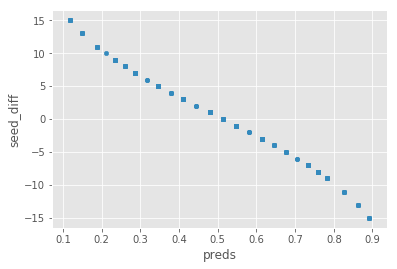

In [66]:
mm_data_2.plot(kind='scatter', x='preds',y='seed_diff')

In [67]:
confusion_matrix(mm_train['team1_win'], mm_train['prediction'])

array([[231, 105],
       [ 93, 251]], dtype=int64)

In [68]:
accuracy_score(mm_data_2['team1_win'], mm_data_2['prediction'])

0.7259475218658892

In [69]:
precision_score(mm_data_2['team1_win'], mm_data_2['prediction'])

0.7314285714285714

In [70]:
recall_score(mm_data_2['team1_win'], mm_data_2['prediction'])

0.7314285714285714

In [71]:
f1_score(mm_data_2['team1_win'], mm_data_2['prediction'])

0.7314285714285713

In [72]:
log_loss(mm_data_2['team1_win'].values, mm_data_2['preds'].values)

0.5689854651775472

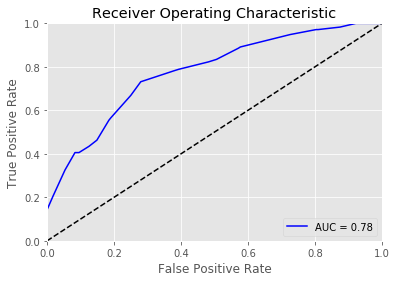

In [73]:
fpr, tpr, thresholds = roc_curve(mm_data_2['team1_win'].values, mm_data_2['preds'].values)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc)

In [74]:
scaler = StandardScaler()
mm_data_else.dropna(subset=['BPI_Diff'], inplace=True)
mm_data_else2.dropna(subset=['BPI_Diff'], inplace=True)
mm_data_2018.dropna(subset=['BPI_Diff'],inplace=True)

mm_train_scaled = scaler.fit_transform(mm_data_else[['team1_log5','diff_dist','seed_diff','BPI_Diff']])
mm_train_scaled2 = scaler.fit_transform(mm_data_else2[['team1_log5','diff_dist','seed_diff','BPI_Diff']])
new_data_scaled = scaler.fit_transform(new_data[['team1_log5','diff_dist','seed_diff','BPI_Diff']])
logit = LogisticRegression()

logit.fit(mm_train_scaled2, mm_data_else2['team1_win'])

NameError: name 'mm_data_else' is not defined

In [ ]:
roc_auc_score(mm_data_2['team1_win'].values, mm_data_2['preds'].values)

In [ ]:
scaler = StandardScaler()
#mm_data_else2.dropna(subset=['BPI_Diff'], inplace=True)
#mm_data_2018.dropna(subset=['BPI_Diff'],inplace=True)

mm_data_scaled = scaler.fit_transform(mm_data[['team1_log5','diff_dist','seed_diff','BPI_Diff']])
#mm_train_scaled2 = scaler.fit_transform(mm_data_else2[['team1_log5','diff_dist','seed_diff','BPI_Diff']])
#new_data_scaled = scaler.fit_transform(new_data[['team1_log5','diff_dist','seed_diff','BPI_Diff']])
logit = LogisticRegression()

logit.fit(mm_data_scaled, mm_data['team1_win'])

In [ ]:
new_data.dropna(subset=['BPI_Diff'], inplace=True)
new_data.dropna(subset=['team1_log5'], inplace=True)
new_data.dropna(subset=['diff_dist'], inplace=True)
new_data.dropna(subset=['seed_diff'], inplace=True)

len(new_data['game_id'])
new_data['preds'] = logit.predict_proba(scaler.fit_transform(new_data[['team1_log5','diff_dist','seed_diff','BPI_Diff']]))[:,1]
len(new_data['preds'])

In [ ]:
predictnew = new_data[['game_id','preds']]

In [ ]:
predictnew.to_csv("predicted.csv")